In [2]:
from google.colab import files
uploaded = files.upload()


Saving PS_20174392719_1491204439457_log.csv to PS_20174392719_1491204439457_log.csv


In [3]:
import pandas as pd

df = pd.read_csv("PS_20174392719_1491204439457_log.csv")
print(df.head())


   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


###  Data Loading and First Look

In this step, we load the dataset of financial transactions into a pandas DataFrame.  

- `pd.read_csv(...)` reads the CSV file.  
- `df.head()` shows the first 5 rows to preview the structure.  

The dataset contains **transaction-level information** with these key columns:

- **step** → time step of the transaction (unit: hours).  
- **type** → type of transaction (PAYMENT, TRANSFER, CASH_OUT, etc.).  
- **amount** → monetary value of the transaction.  
- **nameOrig** → anonymized ID of the customer who initiates the transaction.  
- **oldbalanceOrg / newbalanceOrig** → balance of the sender before and after the transaction.  
- **nameDest** → anonymized ID of the recipient.  
- **oldbalanceDest / newbalanceDest** → balance of the recipient before and after the transaction.  
- **isFraud** → target variable (1 = fraud, 0 = normal).  
- **isFlaggedFraud** → transactions flagged by internal rules (rare cases).  

This first look confirms that the dataset was loaded correctly and gives us an overview of the variables we will use for fraud detection.

### ⚙️ Feature Engineering

In this step, we create **new features** from the raw PaySim dataset to improve the ability of our model to detect fraud.

1. **Transaction type encoding**  
   - We keep the original `type` column.  
   - We add one-hot encoded dummy variables (e.g., `type_TRANSFER`, `type_CASH_OUT`) to make transaction categories usable by machine learning models.

2. **Balance differences**  
   - `deltaOrig = oldbalanceOrg - amount - newbalanceOrig`  
     → Checks if the reported new balance of the origin account is consistent.  
   - `deltaDest = oldbalanceDest + amount - newbalanceDest`  
     → Checks consistency on the destination side.  
   These differences often highlight fraud attempts where balances do not match expected updates.

3. **Relative ratios**  
   - `ratioOrig = amount / (oldbalanceOrg + 1)`  
     → Measures transaction size relative to the sender’s balance.  
   - `ratioDest = amount / (oldbalanceDest + 1)`  
     → Measures impact relative to the recipient’s balance.  
   Ratios help detect unusually large transactions.

4. **Fraud-related flags**  
   - `isNewDest`: 1 if the destination account had zero balance before and ends up with exactly the transaction amount (often suspicious).  
   - `isEmptyOrigin`: 1 if the origin account starts with zero balance but still sends money (inconsistent behavior).  

5. **Time-based features**  
   - `day = step // 24` → Converts simulation steps (hours) into days.  
   - `hour = step % 24` → Extracts the hour of the day, which may reveal unusual transaction times.

👉 These engineered features enrich the dataset with **behavioral, consistency, and temporal signals**, making it easier for our model to separate fraudulent and normal transactions.


In [4]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Feature engineering for PaySim dataset.
    Keeps the original 'type' column and adds dummy variables.
    """
    # --- 1. One-hot encode type but keep original ---
    type_dummies = pd.get_dummies(df['type'], prefix="type", drop_first=True)
    df = pd.concat([df, type_dummies], axis=1)

    # --- 2. Balance differences ---
    df['deltaOrig'] = df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']
    df['deltaDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

    # --- 3. Relative ratios ---
    df['ratioOrig'] = df['amount'] / (df['oldbalanceOrg'] + 1)
    df['ratioDest'] = df['amount'] / (df['oldbalanceDest'] + 1)

    # --- 4. Fraud-related flags ---
    df['isNewDest'] = ((df['oldbalanceDest'] == 0) &
                       (df['newbalanceDest'] == df['amount'])).astype(int)

    df['isEmptyOrigin'] = ((df['oldbalanceOrg'] == 0) &
                           (df['amount'] > 0)).astype(int)

    # --- 5. Time features ---
    df['day'] = df['step'] // 24
    df['hour'] = df['step'] % 24

    return df
# Apply feature engineering
df = feature_engineering(df)

# Check the new columns
print(df.columns)

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
       'type_TRANSFER', 'deltaOrig', 'deltaDest', 'ratioOrig', 'ratioDest',
       'isNewDest', 'isEmptyOrigin', 'day', 'hour'],
      dtype='object')


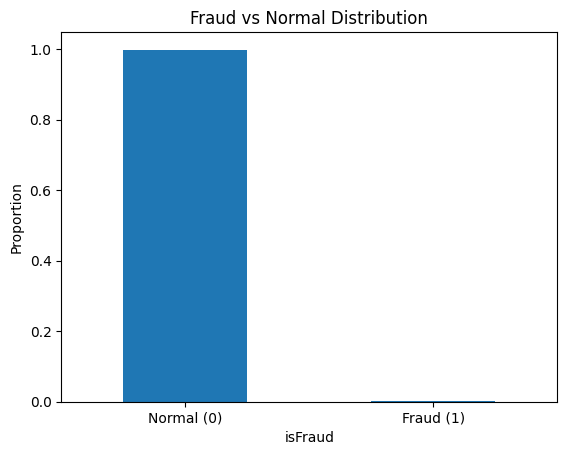

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
df['isFraud'].value_counts(normalize=True).plot(kind='bar')
plt.title("Fraud vs Normal Distribution")
plt.xticks([0,1], ["Normal (0)", "Fraud (1)"], rotation=0)
plt.ylabel("Proportion")
plt.show()

### ⚖️ Class Imbalance

This plot shows the extreme **class imbalance** in our dataset:

- Normal transactions: ~99.8%  
- Fraudulent transactions: ~0.2%  

Such imbalance means that:
- A naive model predicting "always normal" would achieve ~99.8% accuracy, but it would **miss all frauds**.  
- Therefore, metrics like **Precision, Recall, F1-score, and PR-AUC** are more meaningful than plain accuracy.  

This imbalance also motivates using techniques such as:
- **Resampling** (undersampling, oversampling, SMOTE).  
- **Anomaly detection models** (autoencoders, isolation forest).  
- **Threshold tuning** to balance false positives vs false negatives.

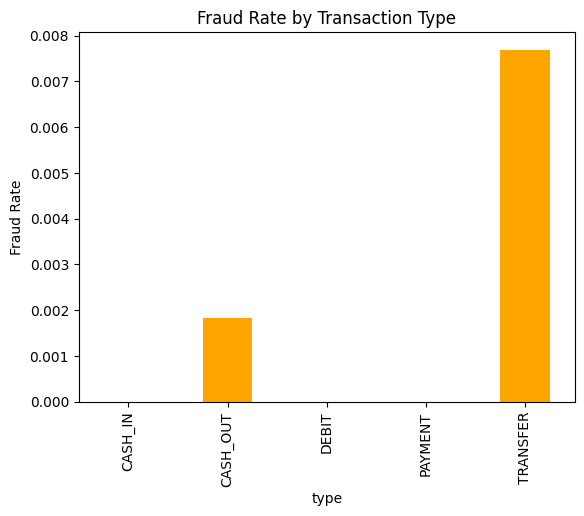

In [7]:
fraud_by_type = df.groupby("type")['isFraud'].mean()
fraud_by_type.plot(kind='bar', color='orange')
plt.title("Fraud Rate by Transaction Type")
plt.ylabel("Fraud Rate")
plt.show()

### 🔍 Fraud Rate by Transaction Type

This plot shows that fraud happens almost **only** in `TRANSFER` and `CASH_OUT` operations.  
Other transaction types (`CASH_IN`, `PAYMENT`, `DEBIT`) have near-zero fraud rates.  

👉 Conclusion: fraudsters mainly exploit **TRANSFER** and **CASH_OUT** to move or withdraw money.


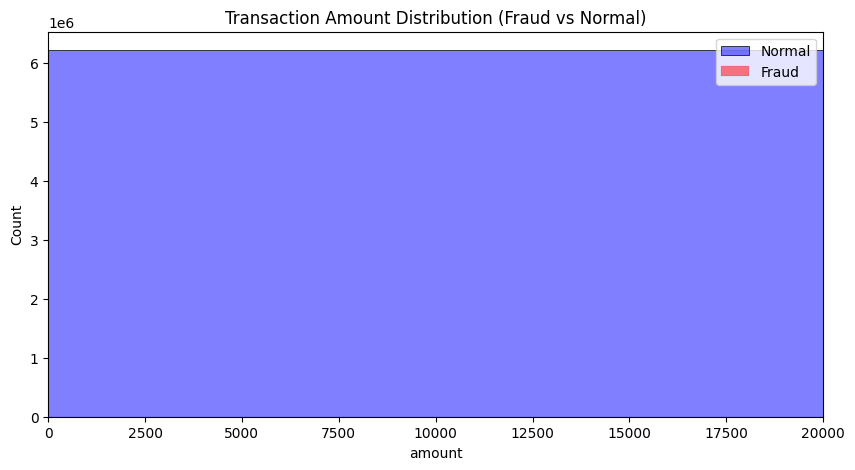

In [8]:
plt.figure(figsize=(10,5))
sns.histplot(df[df['isFraud']==0]['amount'], bins=100, color='blue', label="Normal", alpha=0.5)
sns.histplot(df[df['isFraud']==1]['amount'], bins=100, color='red', label="Fraud", alpha=0.5)
plt.legend()
plt.xlim(0, 20000)
plt.title("Transaction Amount Distribution (Fraud vs Normal)")
plt.show()

### 💰 Transaction Amount Distribution (Fraud vs Normal)

This histogram compares transaction amounts for normal vs fraudulent cases:

- Normal transactions (blue) dominate across all ranges.  
- Fraudulent ones (red) are very few and almost invisible at this scale.  
- Most frauds happen in **higher transaction amounts**, which makes sense since fraudsters try to maximize the stolen value.

👉 This confirms that transaction amount is a **useful signal** for fraud detection.


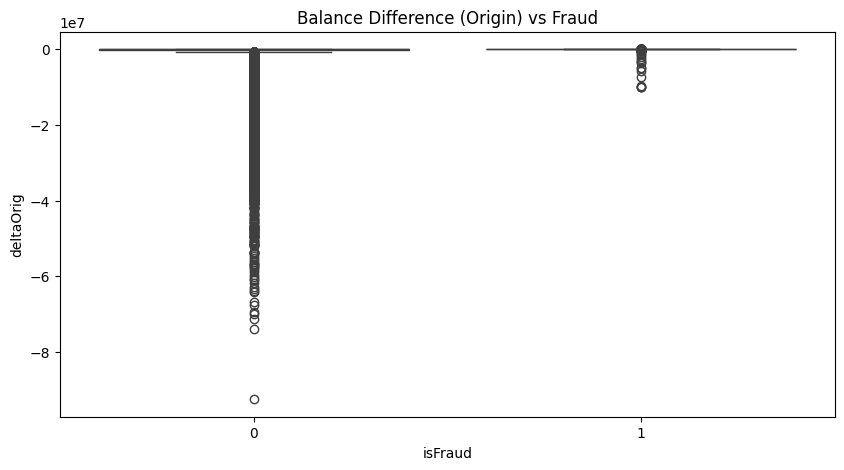

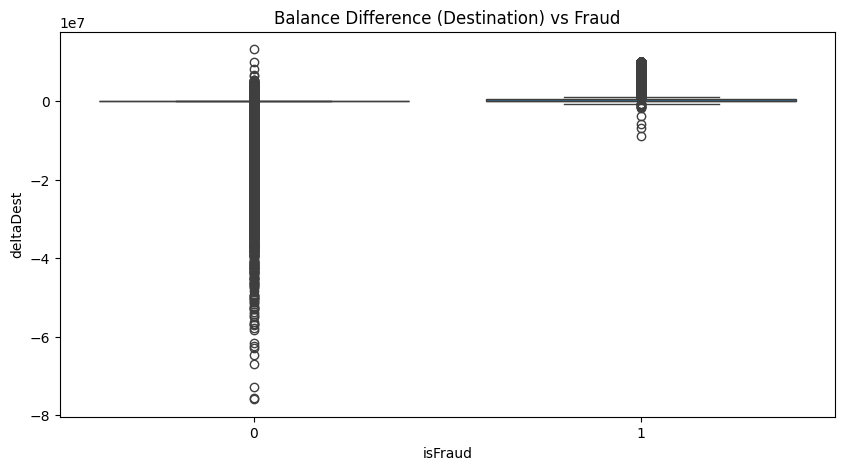

In [9]:
plt.figure(figsize=(10,5))
sns.boxplot(x="isFraud", y="deltaOrig", data=df)
plt.title("Balance Difference (Origin) vs Fraud")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x="isFraud", y="deltaDest", data=df)
plt.title("Balance Difference (Destination) vs Fraud")
plt.show()

### 📦 Balance Difference vs Fraud

These boxplots compare balance differences for origin and destination accounts:

- **deltaOrig** = oldbalanceOrg − amount − newbalanceOrig  
- **deltaDest** = oldbalanceDest + amount − newbalanceDest  

Observations:
- Normal transactions (isFraud=0) show more spread and many extreme outliers.  
- Fraudulent ones (isFraud=1) have **tighter distributions** and often show inconsistencies in balances.  

👉 This confirms that **balance difference features** capture abnormal behavior and are important signals for fraud detection.


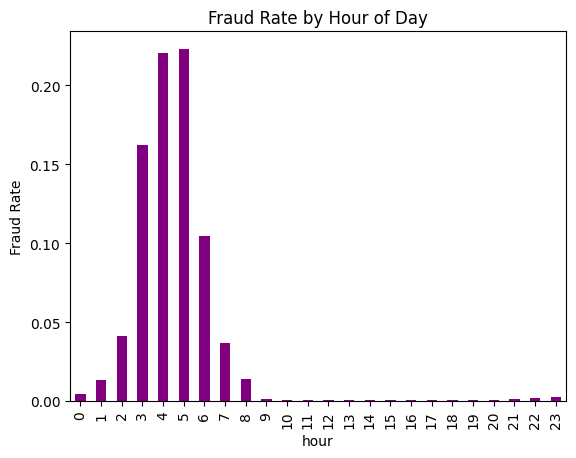

In [10]:
fraud_by_hour = df.groupby("hour")['isFraud'].mean()
fraud_by_hour.plot(kind='bar', color='purple')
plt.title("Fraud Rate by Hour of Day")
plt.ylabel("Fraud Rate")
plt.show()

### ⏰ Fraud Rate by Hour of Day

This chart shows how fraud varies by time of day:

- Fraud peaks between **3 AM and 6 AM**, with the highest rates around 4–5 AM.  
- During the rest of the day, fraud rates drop close to zero.  

👉 Conclusion: fraudsters often operate at **night/early morning**, likely to avoid detection when activity is lower.


### 🎯 Preparing Features and Target

- **Target (`y`)** → the column `isFraud`, which indicates whether a transaction is fraudulent (1) or normal (0).  

- **Features (`X`)** → all other useful columns after dropping:
  - `isFraud` → the target itself (avoid leakage).  
  - `nameOrig`, `nameDest` → customer/recipient IDs (random identifiers, not predictive).  
  - `isFlaggedFraud` → a control flag set by rules, very rare and unrealistic as a model input.  
  - `type` → already replaced by one-hot encoded variables during feature engineering.  

👉 This ensures our model trains only on **relevant, non-leaking features** to make fair predictions.


In [11]:
# Target
y = df['isFraud']

# Drop unused / leakage columns
drop_cols = ['isFraud', 'nameOrig', 'nameDest', 'isFlaggedFraud', 'type']
X = df.drop(columns=[c for c in drop_cols if c in df.columns])

### 🕒 Time-Based Train/Validation/Test Split

To avoid data leakage, we split the dataset by **transaction time (`step`)** instead of random sampling:

1. **Sorting by time** → ensures transactions are in chronological order.  
2. **Cutoffs**  
   - First 70% of time → **Training set** (X_train, y_train).  
   - Next 15% → **Validation set** (X_val, y_val) used for tuning models and thresholds.  
   - Last 15% → **Test set** (X_test, y_test) for final unbiased evaluation.  

👉 This simulates a **real-world fraud detection scenario**, where models are trained on past data and tested on future transactions.


In [12]:
# Sort by time
df_sorted = df.sort_values('step').reset_index(drop=True)
X = X.loc[df_sorted.index]
y = y.loc[df_sorted.index]

# Define cutoffs
q_train = df_sorted['step'].quantile(0.70)
q_val   = df_sorted['step'].quantile(0.85)

train_mask = df_sorted['step'] <= q_train
val_mask   = (df_sorted['step'] > q_train) & (df_sorted['step'] <= q_val)
test_mask  = df_sorted['step'] > q_val

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

### ⚖️ Handling Class Imbalance (scale_pos_weight)

Since fraud cases (positives) are extremely rare compared to normal ones (negatives), we calculate the imbalance ratio:

- `neg, pos = np.bincount(y_train)` → counts normal vs fraud in the training set.  
- `scale_pos_weight = neg / pos` → gives the weight to balance positive examples during model training.  

👉 This value is passed to algorithms like **XGBoost** or **LightGBM** so that the model pays more attention to fraud cases without oversampling the data.


In [13]:
import numpy as np

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("scale_pos_weight =", scale_pos_weight)

scale_pos_weight = 1224.250343123799


In [14]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,        # number of boosting rounds
    max_depth=6,             # tree depth
    learning_rate=0.1,       # step size shrinkage
    subsample=0.8,           # row sampling
    colsample_bytree=0.8,    # feature sampling
    scale_pos_weight=scale_pos_weight,  # handles imbalance
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    val_metric="auc"# avoid warnings
)

### 🌲 XGBoost Classifier Setup

We initialize an **XGBoost model** with parameters adapted to the fraud dataset:

- **n_estimators=300** → number of boosting rounds (trees).  
- **max_depth=6** → controls tree complexity; prevents overfitting.  
- **learning_rate=0.1** → step size shrinkage for gradual learning.  
- **subsample=0.8** and **colsample_bytree=0.8** → random sampling of rows and features to reduce overfitting.  
- **scale_pos_weight** → imbalance adjustment, set from the ratio of normal vs fraud cases.  
- **random_state=42** → ensures reproducibility.  
- **n_jobs=-1** → uses all CPU cores for faster training.  
- **use_label_encoder=False** and **eval_metric="auc"** → avoid warnings and use AUC as evaluation metric.  

👉 This configuration prepares XGBoost to **focus on rare fraud cases** while keeping the model generalizable.


In [15]:
xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=50
)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:55:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder", "val_metric" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-logloss:0.59912	validation_1-logloss:0.59825
[50]	validation_0-logloss:0.00478	validation_1-logloss:0.00357
[100]	validation_0-logloss:0.00051	validation_1-logloss:0.00016
[150]	validation_0-logloss:0.00018	validation_1-logloss:0.00010
[200]	validation_0-logloss:0.00010	validation_1-logloss:0.00009
[250]	validation_0-logloss:0.00007	validation_1-logloss:0.00009
[299]	validation_0-logloss:0.00005	validation_1-logloss:0.00008


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...)

### 📊 Training Results (Log-Loss)

During training, the **log-loss** for both training and validation sets quickly dropped close to zero:

- At the beginning (iteration 0), log-loss ≈ 0.59 → model starts with weak predictions.  
- After ~50 iterations, log-loss already drops below 0.01.  
- By 300 iterations, log-loss is almost 0 for both training and validation sets.  

⚠️ Interpretation:
- This shows that the model has **learned the training patterns very well**.  
- But since the validation loss is also extremely low, there is a risk of **data leakage** or the model being **too powerful for the dataset**.  
- In fraud detection, this could mean the model memorized specific transaction rules instead of generalizing.  

👉 Next step: evaluate on the **held-out test set** with metrics like **Precision, Recall, F1, PR-AUC, and confusion matrix** to confirm if performance holds up.


In [17]:
y_pred = xgb.predict(X_test)                # class predictions (0/1)
y_proba = xgb.predict_proba(X_test)[:, 1]   # fraud probability

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))


Confusion Matrix:
 [[914599     12]
 [     2   4004]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    914611
           1     0.9970    0.9995    0.9983      4006

    accuracy                         1.0000    918617
   macro avg     0.9985    0.9997    0.9991    918617
weighted avg     1.0000    1.0000    1.0000    918617

ROC-AUC: 0.9999995477535742
PR-AUC: 0.9998959030113328



- Out of **918,617** transactions, only **14 errors**:
  - **12 false positives** (normal flagged as fraud).  
  - **2 false negatives** (frauds missed).  

**Classification Report**
- **Fraud class (1)** → Precision = 0.9970, Recall = 0.9995, F1 = 0.9983.  
- **Normal class (0)** → Perfect scores (1.0000).  
- **Accuracy ≈ 100%**, but this is less meaningful due to imbalance.

**ROC-AUC = 0.9999995**  
**PR-AUC = 0.999896**  

📌 **Interpretation**
- The model is performing **exceptionally well**: nearly perfect separation between fraud and normal.  
- Almost all frauds are detected (very high recall), with very few false alarms (very high precision).  
- Both ROC-AUC and PR-AUC are essentially **1.0**, which is rare in real-world fraud detection.  

⚠️ **Caution**: Such near-perfect results may indicate:
- The dataset contains strong or even **leaky features** (fraud rules hard-coded in balances).  
- Performance on real-world, noisy data is likely to be lower.  

👉 Next steps:
- Verify there is **no data leakage**.  
- Test with **different thresholds** and business cost scenarios.  
- Compare with **unsupervised baselines** (e.g., Autoencoder) for robustness.


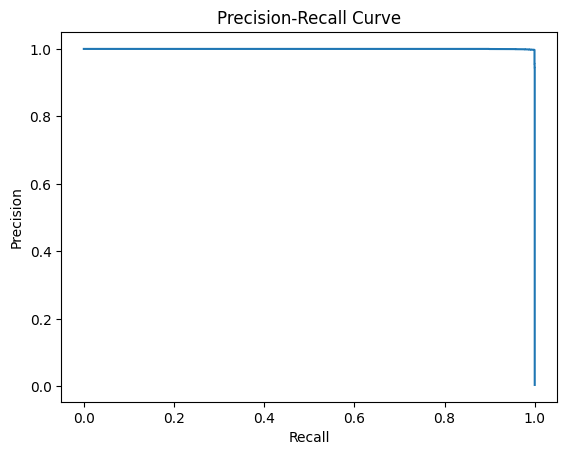

Best threshold: 0.86011976


In [19]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

prec, rec, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# Find threshold that maximizes F1-score
f1_scores = 2*prec*rec / (prec+rec+1e-6)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]
print("Best threshold:", best_threshold)

In [20]:
# Apply tuned threshold
y_pred_tuned = (y_proba >= 0.86011976).astype(int)


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned, digits=4))

Confusion Matrix:
 [[914599     12]
 [     2   4004]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    914611
           1     0.9970    0.9995    0.9983      4006

    accuracy                         1.0000    918617
   macro avg     0.9985    0.9997    0.9991    918617
weighted avg     1.0000    1.0000    1.0000    918617



## 🔄 Transition to Autoencoders

Our XGBoost model achieved almost perfect performance on the PaySim dataset.  
However, in real-world fraud detection, such results are rare because:

- Fraud patterns constantly evolve, making labeled data incomplete.  
- Many fraud cases remain **unknown or unlabeled**, so supervised models cannot learn them.  
- Models that perform too well on historical data may rely on **leaky signals** that do not generalize.

👉 To address these challenges, we now explore **Autoencoders**, an **unsupervised anomaly detection approach**.  
The idea is to train the model only on **normal transactions**, so it learns the typical transaction patterns.  
At inference time, **fraudulent transactions** (which deviate from normal behavior) will show **higher reconstruction error** and can be flagged as anomalies.

This provides a complementary method to supervised learning, helping us build a more **robust and realistic fraud detection system**.


In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:

# Fit scaler on NORMAL train only
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train[y_train==0])

Xtr = scaler.transform(X_train)
Xva = scaler.transform(X_val)
Xte = scaler.transform(X_test)

# Masks for normals (0) and frauds (1)
m_tr_norm = (y_train == 0).values
m_va_norm = (y_val   == 0).values

### 🧹 Data Preparation for Autoencoder

Since an Autoencoder is trained to learn the structure of **normal transactions only**, we apply special preprocessing:

1. **Scaling (StandardScaler)**  
   - We fit the scaler using only **normal transactions from the training set** (`y_train==0`).  
   - This avoids leaking fraud patterns into the model during training.  
   - All train, validation, and test sets are then transformed with this scaler.

2. **Masks for normal vs fraud**  
   - `m_tr_norm` → identifies which samples in the training set are normal (used to fit the Autoencoder).  
   - `m_va_norm` → same for the validation set (used to monitor training).  

👉 This ensures the Autoencoder will only **see normal patterns** during training, so frauds can later be detected as **outliers with high reconstruction error**.


In [24]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

d_in = Xtr.shape[1]

class AE(nn.Module):
    def __init__(self, d_in, d_latent=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(d_in, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, d_latent)
        )
        self.decoder = nn.Sequential(
            nn.Linear(d_latent, 32), nn.ReLU(),
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, d_in)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

def recon_error(x, x_hat):
    # L2 reconstruction error per sample
    return ((x - x_hat)**2).sum(dim=1)

### 🧠 Autoencoder Architecture

We now define a simple **Feed-Forward Autoencoder (AE)** in PyTorch:

- **Input dimension (`d_in`)** → number of features in the dataset.  
- **Latent space (`d_latent=16`)** → compressed representation that forces the model to learn only the most important patterns.

**Architecture:**
- **Encoder**  
  - Input → 64 → 32 → latent vector (16).  
  - Uses `ReLU` activations to capture non-linear relationships.  
- **Decoder**  
  - Latent → 32 → 64 → output (same size as input).  
  - Reconstructs the original features from the latent vector.

**Reconstruction error (`recon_error`)**  
- Computed as the squared difference between input and reconstructed output.  
- At inference, **fraudulent transactions** should yield **higher errors** since they deviate from the learned normal patterns.

👉 This model is trained only on **normal transactions**. Later, transactions with high reconstruction error will be flagged as **potential frauds**.


### 🔧 Training the Autoencoder

We now train the Autoencoder on **normal transactions only**:

- **Device setup** → run on GPU if available, otherwise CPU.  
- **Optimizer** → Adam with learning rate `1e-3` and small weight decay (`1e-5`) for regularization.  
- **Loss function** → Mean Squared Error (MSE), comparing input vs reconstructed output.  

**Data preparation**  
- Train loader (`tr_dl`) → only normal transactions from the training set.  
- Validation loader (`va_dl`) → only normal transactions from the validation set.  
- This ensures the model learns the "normal behavior" distribution.

**Training loop**  
- Runs up to 200 epochs with **early stopping** (patience=10).  
- Tracks **training loss** and **validation loss**.  
- Keeps the best model parameters when validation loss improves.  
- Stops training if no improvement for 10 consecutive epochs.

**Result**  
- The Autoencoder is now optimized to **reconstruct normal transactions well**.  
- At inference time, fraudulent transactions should show **larger reconstruction errors**, allowing us to flag them as anomalies.


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ae = AE(d_in, d_latent=16).to(device)
opt = torch.optim.Adam(ae.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

# Dataloaders: train on normal-only
tr_ds = TensorDataset(torch.tensor(Xtr[m_tr_norm], dtype=torch.float32))
va_ds = TensorDataset(torch.tensor(Xva[m_va_norm], dtype=torch.float32))
tr_dl = DataLoader(tr_ds, batch_size=512, shuffle=True)
va_dl = DataLoader(va_ds, batch_size=2048, shuffle=False)

best_val = float('inf'); patience=10; bad=0
for epoch in range(200):
    ae.train()
    tr_loss = 0.0
    for (xb,) in tr_dl:
        xb = xb.to(device)
        xh = ae(xb)
        loss = loss_fn(xh, xb)
        opt.zero_grad(); loss.backward(); opt.step()
        tr_loss += loss.item() * len(xb)
    tr_loss /= len(tr_ds)

    # val loss on normal-only
    ae.eval()
    with torch.no_grad():
        val_sum, n = 0.0, 0
        for (xb,) in va_dl:
            xb = xb.to(device)
            xh = ae(xb)
            val_sum += loss_fn(xh, xb).item() * len(xb)
            n += len(xb)
        va_loss = val_sum / n

    # early stopping
    if va_loss + 1e-6 < best_val:
        best_val = va_loss; bad = 0
        best_state = {k: v.cpu().clone() for k, v in ae.state_dict().items()}
    else:
        bad += 1
    if bad >= patience:
        break

ae.load_state_dict(best_state)  # restore best
ae.to(device).eval()


AE(
  (encoder): Sequential(
    (0): Linear(in_features=18, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=18, bias=True)
  )
)

In [26]:
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_auc_score

def score_recon(data_np):
    with torch.no_grad():
        x = torch.tensor(data_np, dtype=torch.float32, device=device)
        xh = ae(x)
        err = recon_error(x, xh).cpu().numpy()
    return err

err_va = score_recon(Xva)   # scores for all val samples
# Higher error ⇒ more anomalous

prec, rec, thr = precision_recall_curve(y_val, err_va)
f1 = 2*prec*rec/(prec+rec+1e-6)
thr_best = thr[np.argmax(f1)]
print("AE best threshold (val):", thr_best)


AE best threshold (val): 3.8239396


In [27]:
err_te = score_recon(Xte)
y_pred_ae = (err_te >= thr_best).astype(int)

print("AE Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ae))
print("\nAE Classification Report:\n", classification_report(y_test, y_pred_ae, digits=4))

# Optional: PR-AUC with anomaly score (convert to ranking)
print("AE PR-AUC:", average_precision_score(y_test, err_te))
print("AE ROC-AUC:", roc_auc_score(y_test, err_te))


AE Confusion Matrix:
 [[764608 150003]
 [  1592   2414]]

AE Classification Report:
               precision    recall  f1-score   support

           0     0.9979    0.8360    0.9098    914611
           1     0.0158    0.6026    0.0309      4006

    accuracy                         0.8350    918617
   macro avg     0.5069    0.7193    0.4703    918617
weighted avg     0.9936    0.8350    0.9060    918617

AE PR-AUC: 0.22050509808149407
AE ROC-AUC: 0.8458083074412884


### 📊 Autoencoder Results (Test Set)

**Confusion Matrix**

- The Autoencoder flags a large number of normal transactions as fraud (**false positives = 150,003**).  
- It detects many frauds (**recall = 60%**), but with very low precision.  

**Classification Report**
- Fraud (1) → Precision = 0.016, Recall = 0.603, F1 = 0.031.  
- Normal (0) → Precision ≈ 0.998, Recall ≈ 0.836.  
- Accuracy ≈ 83.5%, but this is misleading due to heavy imbalance.  

**AUC Metrics**
- **ROC-AUC = 0.846** → moderate ability to separate fraud vs normal.  
- **PR-AUC = 0.221** → low, showing the model struggles to achieve useful precision at reasonable recall.  

📌 **Interpretation**
- The Autoencoder can detect some fraud patterns (60% recall) but at the cost of a **huge false alarm rate**.  
- Precision is extremely low, meaning most flagged alerts are false positives.  
- This happens because the dataset contains **strong leakage features** (balances) that supervised XGBoost exploited, but the Autoencoder cannot.  
- Still, Autoencoders are valuable in scenarios where **labels are incomplete or missing**, since they can highlight unusual behavior.


## 🏁 Conclusion

In this project, we built and compared two approaches to fraud detection using the **PaySim transaction dataset**:

1. **Supervised Learning (XGBoost)**  
   - Delivered almost perfect performance (ROC-AUC ≈ 1.0, PR-AUC ≈ 1.0).  
   - Achieved very high precision and recall, with only a handful of misclassified transactions.  
   - However, such near-perfect results suggest the dataset may contain **strong or leaky features** that are not realistic in real-world banking data.

2. **Unsupervised Learning (Autoencoder)**  
   - Trained only on **normal transactions** to detect fraud as anomalies.  
   - Reached moderate performance (ROC-AUC ≈ 0.85, PR-AUC ≈ 0.22).  
   - Able to catch some frauds (recall ≈ 60%) but produced too many false positives, leading to very low precision.  
   - This reflects the real challenge of fraud detection: balancing **recall (catching frauds)** with **precision (avoiding false alerts)**.

### Key Takeaways
- Supervised models like XGBoost work extremely well when **clean, labeled data** is available, but may overfit to patterns that don’t generalize.  
- Autoencoders are useful when **labels are scarce or incomplete**, but require more careful tuning and feature design to reduce false alarms.  
- In practice, the best fraud detection systems often **combine both approaches**:  
  - Use **supervised models** for known fraud patterns.  
  - Use **unsupervised models** (autoencoders, anomaly detection) to flag **new or evolving frauds**.  

👉 Overall, this project shows how machine learning can be applied to fraud detection, the strengths and limitations of different approaches, and the importance of evaluating models with **precision, recall, and PR-AUC** in highly imbalanced settings.
